In [2]:
import json
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches
from tqdm import tqdm
import os

In [2]:
#load predicted relations(attributes_with) on Test including gt
with open("./Outputs/imat_attr_test_gt_step499999/rel_detections.pkl","rb") as f:
    rel_output = pickle.load(f)
with open('./data/imaterialist/predicates_attributes.json') as f:#list of predicates (edges of the graph) which includes "with" + "all attributes"
    prd_cats = json.load(f)
with open('./data/imaterialist2/test_detections.json', 'rb') as handle:
    categories = json.load(handle)
    categories = categories["categories"]
    categories_id_to_name = {cat["id"]:cat["name"] for cat in categories}

In [3]:
with open("./data/imaterialist2/mask_id_to_color2.json","r+") as f:
    img_to_color = json.load(f)
color_dct = {1:"black",2:"blue",3:"green",4:"cyan",5:"red",6:"maginta",7:"yellow",8:"white"}

In [168]:
"""with open('./data/imaterialist2/predicates_counter.json') as f:
    predicate_counter = json.load(f)
sum_c = sum(list(predicate_counter.values())[1:])
attr_waights = np.array([sum_c/predicate_counter[str(i)] if str(i) in predicate_counter and sum_c/predicate_counter[str(i)]<1000 else 0 for i in range(len(prd_cats))])

"""
main_categories = {cat["id"]:cat["name"] for cat in categories if cat["supercategory"] in ['upperbody','lowerbody','wholebody']}
main_categories

{0: 'shirt, blouse',
 1: 'top, t-shirt, sweatshirt',
 2: 'sweater',
 3: 'cardigan',
 4: 'jacket',
 5: 'vest',
 6: 'pants',
 7: 'shorts',
 8: 'skirt',
 9: 'coat',
 10: 'dress',
 11: 'jumpsuit',
 12: 'cape'}

## SG representation

In [72]:
def get_limits_of_bbox(sbj_bboxes,obj_boxes):
    sbj_bboxes = np.asarray(sbj_bboxes)
    obj_boxes = np.asarray(obj_boxes)
    list_bboxes = np.concatenate((sbj_bboxes,obj_boxes))
    Xs, Ys, Ws, Hs =  list_bboxes.T
    crop_right = min (Xs) 
    crop_upper = min(Ys)
    crop_left = max(Xs+Ws)
    crop_lower = max(Ys+Hs)
    return (crop_right-2,crop_upper-2,crop_left+2,crop_lower+2)
get_limits_of_bbox(rel_output[78 ]['gt_sbj_boxes'] , rel_output[78]['gt_obj_boxes'])  


(715, 560, 1618, 1748)

## Retrieva Process: from model scores to retrieval score

In [8]:
class SG2Vec:
    """
    #score1= ***_obj_membership = what (main) objects appear (0 or 1) 
    #score2= what hierarchies appear (rel with) (score > thresh_with)
    #score3= what attributes (only main objects?)(score >thresh_attr)
    #score4= color(object,rgb)
    #similarity = (s1_gt dot s1_2 +  s2_gt dot s2_2  +  s3_gt dot s3_2  +  s4_gt dot s4_2)
    """
    
    def __init__(self, objects, main_objects, predicates,thr_obj=0.2, thr_with=0.1, thr_attr=0.09):
        
        self.objects = objects
        self.num_obj = len(self.objects)
        self.main_objects = main_objects
        self.num_main_obj = len(self.main_objects) 
        self.predicates = predicates
        self.num_prd = len(self.predicates)#with + attr
        self.thr_with = thr_with
        self.thr_attr = thr_attr
        self.thr_obj = thr_obj

    def _encode_color(self,rgb):
        """rgb to 8-color pallete"""
        r = "1" if rgb[0] > 127 else "0"
        g = "1" if rgb[1] > 127 else "0"
        b = "1" if rgb[2] > 127 else "0"
        
        for i in range(8):
            if r+g+b == format(i, '03b'):
                return i+1
            
    def get_scores(self, img_relations, color_list ):
        #common between gt and pred
        main_obj_index = { original_id:i for i, original_id in enumerate(self.main_objects.keys())}
        
        #1. gt annotations
        #1.1 gt_score1
        gt_obj_membership = np.zeros(self.num_main_obj)
        #1.2 gt_score2
        gt_rel_membership = np.zeros((self.num_obj , self.num_obj))
        #1.3 gt_score3
        gt_attr_membership = np.zeros((self.num_obj , self.num_prd))#including with
        #1.4 gt_score4
        gt_color_membership = np.zeros(self.num_obj )#3bit color=8 colors
        for maskid,catid,color in color_list:
            gt_color_membership[catid] = self._encode_color(color)
                
        
        for gt_prd, gt_sbj, gt_obj in zip(img_relations['gt_prd_labels'],img_relations['gt_sbj_labels'],img_relations['gt_obj_labels']):
            #1.1
            if gt_sbj in self.main_objects:
                gt_obj_membership[main_obj_index[gt_sbj]] = 1
            if gt_sbj in self.main_objects:
                gt_obj_membership[main_obj_index[gt_sbj]] = 1
            
            #1.2
            if gt_prd == 0: #with
                gt_rel_membership[gt_sbj , gt_obj] = 1
            
            #1.3
            gt_attr_membership[gt_sbj , gt_prd] = 1
            gt_attr_membership[gt_obj , gt_prd] = 1
            gt_attr_membership[gt_sbj , 0] = 0
            gt_attr_membership[gt_obj , 0] = 0
            
            #1.4


            
        #2. predicted annotations   
        #2.1 pred_score1
        pred_obj_membership = np.zeros(self.num_main_obj)
        #2.2 pred_score2
        pred_rel_membership = np.zeros((self.num_obj , self.num_obj))
        #2.3 pred_score3
        pred_attr_membership = np.zeros((self.num_obj , self.num_prd))#self.num_prd is including with
        for sbj, obj, sbj_score, obj_score, prd_scores in zip(img_relations['sbj_labels'],img_relations['obj_labels'],img_relations['sbj_scores'],img_relations['obj_scores'],img_relations['prd_scores_ttl']):
            #2.1
            if sbj in self.main_objects and sbj_score>0.9:
                pred_obj_membership[main_obj_index[sbj]] = 1
            if obj in self.main_objects and obj_score>0.9:
                pred_obj_membership[main_obj_index[obj]] = 1
            #2.2
            with_score = prd_scores[1]#0th:background #1st: with #2nd:344th attributes
            pred_rel_membership[sbj,obj] = 1 if sbj_score * obj_score > self.thr_obj and with_score > self.thr_with else 0
            
            #2.3
            attr_scores =  prd_scores[1:self.num_prd+1]#excluding background
            attr_scores[0]=0 #excluding with
            attr_scores = np.array([ (0 if sbj_score * obj_score *score < self.thr_attr else 1) for score in attr_scores])
            
            #if sbj_score * obj_score > self.thr_obj and with_score > self.thr_with:
            #    attr_scores[0] = 10 if sbj in self.main_objects or obj in self.main_objects else 1#giving more priority to main clothing 
            
            pred_attr_membership[obj, :] = np.maximum(pred_attr_membership[obj, :],attr_scores)
            pred_attr_membership[sbj, :] = np.maximum(pred_attr_membership[sbj, :],attr_scores)
        
        return {"pred_score1":pred_obj_membership, "pred_score2":pred_rel_membership, "pred_score3":pred_attr_membership,
                "gt_score1":gt_obj_membership, "gt_score2":gt_rel_membership, "gt_score3":gt_attr_membership,"gt_score4":gt_color_membership
               }
        
    
            

In [152]:
#7,14,56,38,26,3890
sg2vec = SG2Vec(categories_id_to_name,categories_id_to_name, prd_cats)
scores = sg2vec.get_scores(rel_output[38 ],img_to_color[os.path.basename(rel_output[1 ]["image"])])
print([(categories_id_to_name[i],prd_cats[j]) for i, j in np.argwhere(scores["gt_score3"] > 0)])
print("")
print([(categories_id_to_name[i],prd_cats[j]) for i, j in np.argwhere(scores["pred_score3"] > 0)])
print("")
print([(categories_id_to_name[i],categories_id_to_name[j]) for i, j in np.argwhere(scores["gt_score2"] > 0)])
print("")
print([(categories_id_to_name[i],categories_id_to_name[j]) for i, j in np.argwhere(scores["pred_score2"] > 0)])
print("")
print([categories_id_to_name[i[0]] for i in np.argwhere(scores["gt_score1"] > 0)])
print("")
print([categories_id_to_name[i[0]]  for i in np.argwhere(scores["pred_score1"] > 0)])
print("")
print([(categories_id_to_name[i[0]],color_dct[scores["gt_score4"][i[0]]]) for i in np.argwhere(scores["gt_score4"] > 0)])

[('shirt, blouse', 'symmetrical'), ('shirt, blouse', 'regular (fit)'), ('shirt, blouse', 'normal waist'), ('shirt, blouse', 'above-the-hip (length)'), ('shirt, blouse', 'single breasted'), ('shirt, blouse', 'no non-textile material'), ('shirt, blouse', 'no special manufacturing technique'), ('shirt, blouse', 'plain (pattern)'), ('sweater', 'symmetrical'), ('sweater', 'tight (fit)'), ('sweater', 'normal waist'), ('sweater', 'above-the-hip (length)'), ('sweater', 'no non-textile material'), ('sweater', 'no special manufacturing technique'), ('sweater', 'plain (pattern)'), ('pants', 'leggings'), ('pants', 'symmetrical'), ('pants', 'peg'), ('pants', 'normal waist'), ('pants', 'maxi (length)'), ('pants', 'fly (opening)'), ('pants', 'no non-textile material'), ('pants', 'no special manufacturing technique'), ('pants', 'plain (pattern)'), ('collar', 'shirt (collar)'), ('sleeve', 'three quarter (length)'), ('sleeve', 'wrist-length'), ('sleeve', 'set-in sleeve'), ('neckline', 'scoop (neck)')]



In [262]:
thr_with=0.1 #for paper 0.1 & 0.02
thr_attr=0.09
file_name = "./data/imaterialist2/sg2vec_test_"+str(thr_with)+"_"+str(attr_score_thr)+".pkl"
#sg2vec = SG2Vec(categories_id_to_name,categories_id_to_name, prd_cats,thr_with=thr_with,thr_attr=thr_attr )
#SG2Vec_test = [sg2vec.get_scores(img,img_to_color[os.path.basename(img["image"])]) for img in tqdm(rel_output)]
#with open(file_name , "wb") as f:
#    np.save(f,np.array(SG2Vec_test))

In [263]:
with open(file_name,"rb") as f:
    SG2Vec_test = np.load(f,allow_pickle=True)

In [264]:

pred_score1 = np.array([img_scores["pred_score1"] for img_scores in SG2Vec_test])
gt_score1 = np.array([img_scores["gt_score1"] for img_scores in SG2Vec_test])
pred_score2 = np.array([img_scores["pred_score2"].flatten() for img_scores in SG2Vec_test])
gt_score2 = np.array([img_scores["gt_score2"].flatten() for img_scores in SG2Vec_test])
pred_score3 = np.array([(img_scores["pred_score3"]).flatten() for img_scores in SG2Vec_test])
gt_score3 = np.array([(img_scores["gt_score3"]).flatten() for img_scores in SG2Vec_test])
gt_score4 = np.array([img_scores["gt_score4"] for img_scores in SG2Vec_test])

In [265]:
pred_score1_similarity_matrix = np.matmul(pred_score1,pred_score1.T)
gt_score1_similarity_matrix = np.matmul(gt_score1,gt_score1.T)
pred_score2_similarity_matrix = np.matmul(pred_score2,pred_score2.T)
gt_score2_similarity_matrix = np.matmul(gt_score2,gt_score2.T)
pred_score3_similarity_matrix = np.matmul(pred_score3,pred_score3.T)
gt_score3_similarity_matrix = np.matmul(gt_score3,gt_score3.T)

from sklearn.metrics.pairwise import cosine_similarity
gt_score4_similarity_matrix = cosine_similarity(gt_score4)


dress
collar
sleeve
dress is white
belt is white
collar is white
sleeve is white
shirt, blouse is shirt
shirt, blouse is symmetrical
skirt is shirt
dress is shirt
dress is symmetrical
sleeve is short
collar belongs to shirt, blouse
collar belongs to dress

dress
collar
sleeve
dress is white
belt is white
collar is white
sleeve is white
dress is shirt
dress is symmetrical
dress is trumpet
dress is high waist
dress is single breasted
dress is no non-textile material
dress is rivet(a)
dress is plain
collar is shirt
sleeve is short
belt belongs to dress
collar belongs to dress
sleeve belongs to dress

dress
collar
sleeve
collar is white
sleeve is white
shirt, blouse is shirt
shirt, blouse is symmetrical
dress is shirt
dress is symmetrical
collar belongs to shirt, blouse
collar belongs to dress

dress
collar
sleeve
collar is white
dress is shirt
dress is symmetrical
dress is high waist
dress is single breasted
dress is no non-textile material
dress is plain
sleeve is short
belt belongs to d

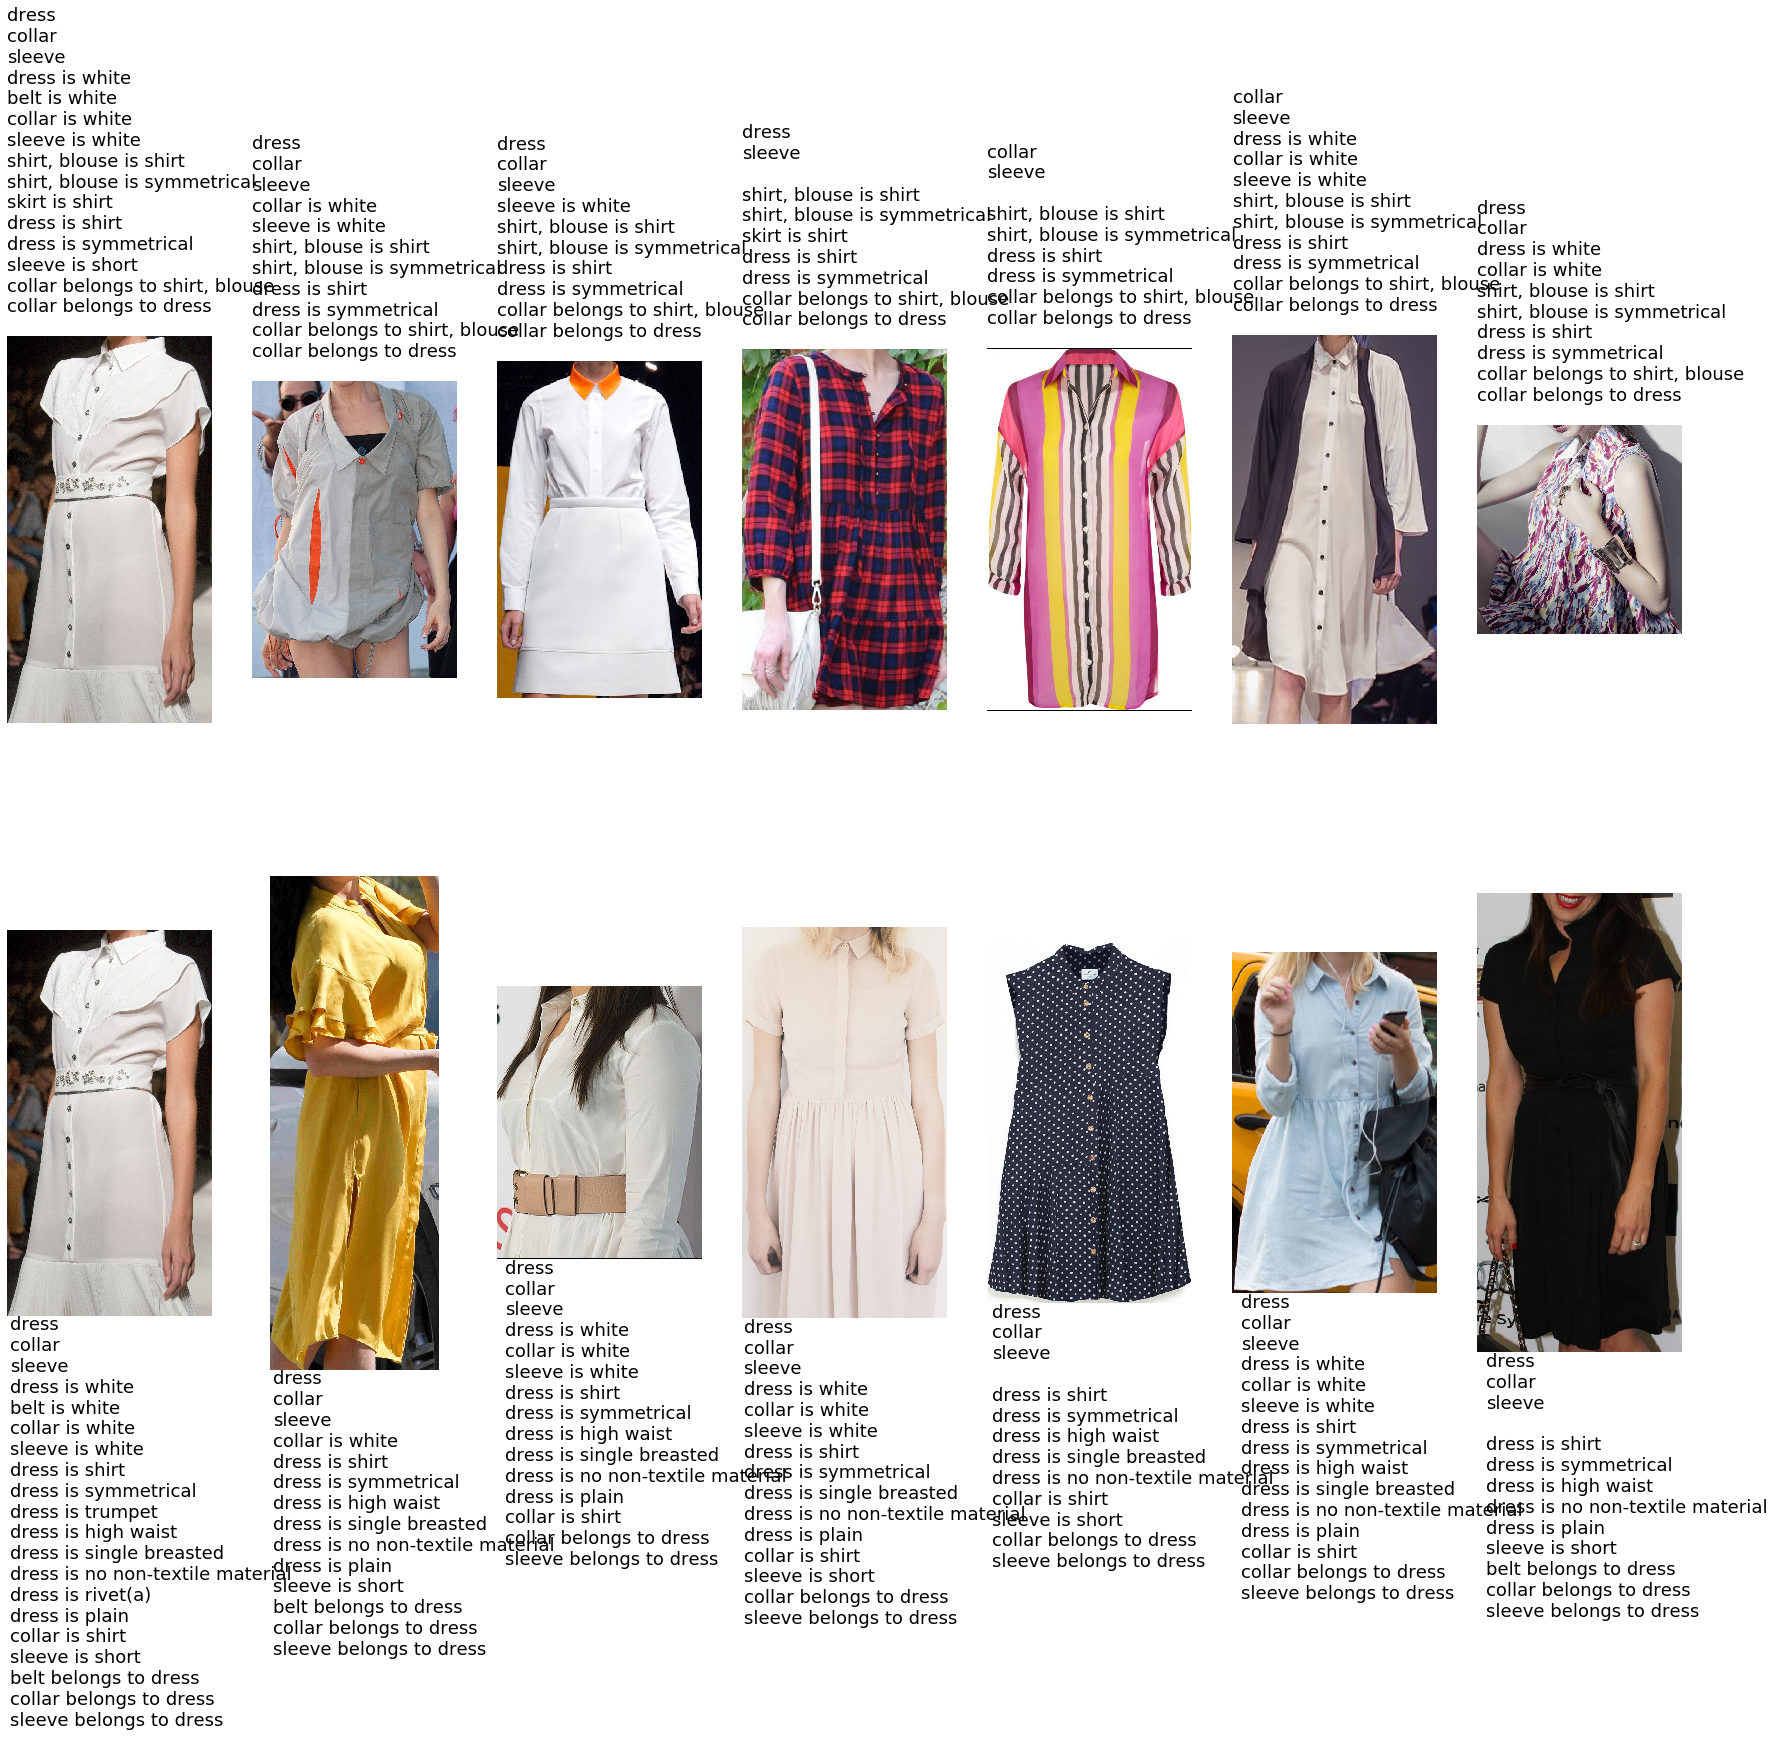

In [268]:
img_ind = 7 #988#3#15#16
score1=True
score2=True
score3=True
score4 = True
truncate_title_at =250

pred_sim_score = np.zeros(len(pred_score3_similarity_matrix[img_ind]))
gt_sim_score = np.zeros(len(gt_score3_similarity_matrix[img_ind]))

if score1:
    pred_sim_score +=  pred_score1_similarity_matrix[img_ind]        
if score2:
    pred_sim_score +=  pred_score2_similarity_matrix[img_ind]        
if score3:
    pred_sim_score +=  pred_score3_similarity_matrix[img_ind]
if score4:
    pred_sim_score += gt_score4_similarity_matrix[img_ind]
    gt_sim_score += gt_score4_similarity_matrix[img_ind]
    

gt_sim_score += gt_score2_similarity_matrix[img_ind]    
gt_sim_score += gt_score3_similarity_matrix[img_ind]    
gt_sim_score += gt_score1_similarity_matrix[img_ind]
gt_sim_score[img_ind] = 99999999999 #the query image should be on top
pred_sim_score[img_ind] = 9999999999
        
num_rows =2
num_cols = 7

plt.figure(figsize=(30, 20))
plt.axis('off')

i=1
for pred_id, pred_similarity,gt_id, gt_similarity in zip(np.argsort(pred_sim_score)[:-1-num_cols:-1],
                                                        np.sort(pred_sim_score)[:-1-num_cols:-1],
                                                        np.argsort(gt_sim_score)[:-1-num_cols:-1],
                                                        np.sort(gt_sim_score)[:-1-num_cols:-1]):
    #print(" ")
    #print(pred_id, pred_score1_similarity_matrix[pred_id][img_ind],pred_score3_similarity_matrix[pred_id][img_ind],pred_similarity,gt_id, gt_similarity)
    title_pred = ""
    
    if score1:
        matched = [str((categories_id_to_name[i]))[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[pred_id]["pred_score1"][:,None]*SG2Vec_test[img_ind]["pred_score1"][:,None] > 0)]
        title_pred += "\n".join(matched)+"\n"
    if score4:
        matched = [(categories_id_to_name[i]+" is "+color_dct[SG2Vec_test[pred_id]["gt_score4"][i]])[:truncate_title_at] for i,j in np.argwhere(np.logical_and(SG2Vec_test[pred_id]["gt_score4"][:,None]==SG2Vec_test[img_ind]["gt_score4"][:,None] , SG2Vec_test[img_ind]["gt_score4"][:,None]>0, SG2Vec_test[pred_id]["gt_score4"][:,None]>0))]
        title_pred += "\n".join(matched)+"\n"
    if score3:
        matched = [(categories_id_to_name[i]+" is "+prd_cats[j].split(" (")[0])[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[pred_id]["pred_score3"]*SG2Vec_test[img_ind]["pred_score3"] > 0)]
        title_pred += "\n".join(matched)+"\n"
    if score2:
        matched = [(categories_id_to_name[j] + " belongs to "+ categories_id_to_name[i])[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[pred_id]["pred_score2"]*SG2Vec_test[img_ind]["pred_score2"] > 0)]
        title_pred += "\n".join(matched)+"\n"
    
    print(title_pred)
    title_gt = ""
    if score1:
        matched = [str((categories_id_to_name[i]))[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[gt_id]["gt_score1"][:,None]*SG2Vec_test[img_ind]["gt_score1"][:,None] > 0)]
        title_gt += "\n".join(matched)+"\n"
    
    if score4:
        matched = [(categories_id_to_name[i]+" is "+color_dct[SG2Vec_test[gt_id]["gt_score4"][i]])[:truncate_title_at] for i,j in np.argwhere(np.logical_and(SG2Vec_test[gt_id]["gt_score4"][:,None]==SG2Vec_test[img_ind]["gt_score4"][:,None] , SG2Vec_test[img_ind]["gt_score4"][:,None]>0, SG2Vec_test[gt_id]["gt_score4"][:,None]>0))]
        title_gt += "\n".join(matched)+"\n"
    
    if score3:
        matched = [(categories_id_to_name[i]+" is "+prd_cats[j].split(" (")[0])[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[gt_id]["gt_score3"]*SG2Vec_test[img_ind]["gt_score3"] > 0)]
        title_gt += "\n".join(matched)+"\n"
    
    if score4:
        matched = [(categories_id_to_name[j] + " belongs to "+ categories_id_to_name[i])[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[gt_id]["gt_score2"]*SG2Vec_test[img_ind]["gt_score2"] > 0)]
        title_gt += "\n".join(matched)+"\n"
    
    plt.subplot(num_rows, num_cols, i)
    plt.axis('off')
    img = Image.open(rel_output[pred_id]["image"])
    img = img.crop(get_limits_of_bbox(rel_output[pred_id]['gt_sbj_boxes'] , rel_output[pred_id]['gt_obj_boxes']) ) 
    #img.save( "./Fig52/"+str(score1)+str(score2)+str(score3)+str(score4)+str(i)+".jpg")
    plt.imshow(np.asarray(img).astype(np.uint8))
    plt.text(0, 0, title_pred, fontsize=18,verticalalignment="bottom")
    print(title_gt)

    
    plt.subplot(num_rows, num_cols, i+num_cols)
    plt.axis('off')
    img = Image.open(rel_output[gt_id]["image"])
    img = img.crop(get_limits_of_bbox(rel_output[gt_id]['gt_sbj_boxes'] , rel_output[gt_id]['gt_obj_boxes'])  )    
    img.save( "./Fig52/"+"gt"+str(i)+".jpg")
    plt.imshow(np.asarray(img).astype(np.uint8))
    plt.text(15, img.size[1] , title_gt, fontsize=18,verticalalignment="top")
    i+=1
    
plt.show()    

### same experiment but instead of sum data are ranked by oder of scores(ordered by multi column)

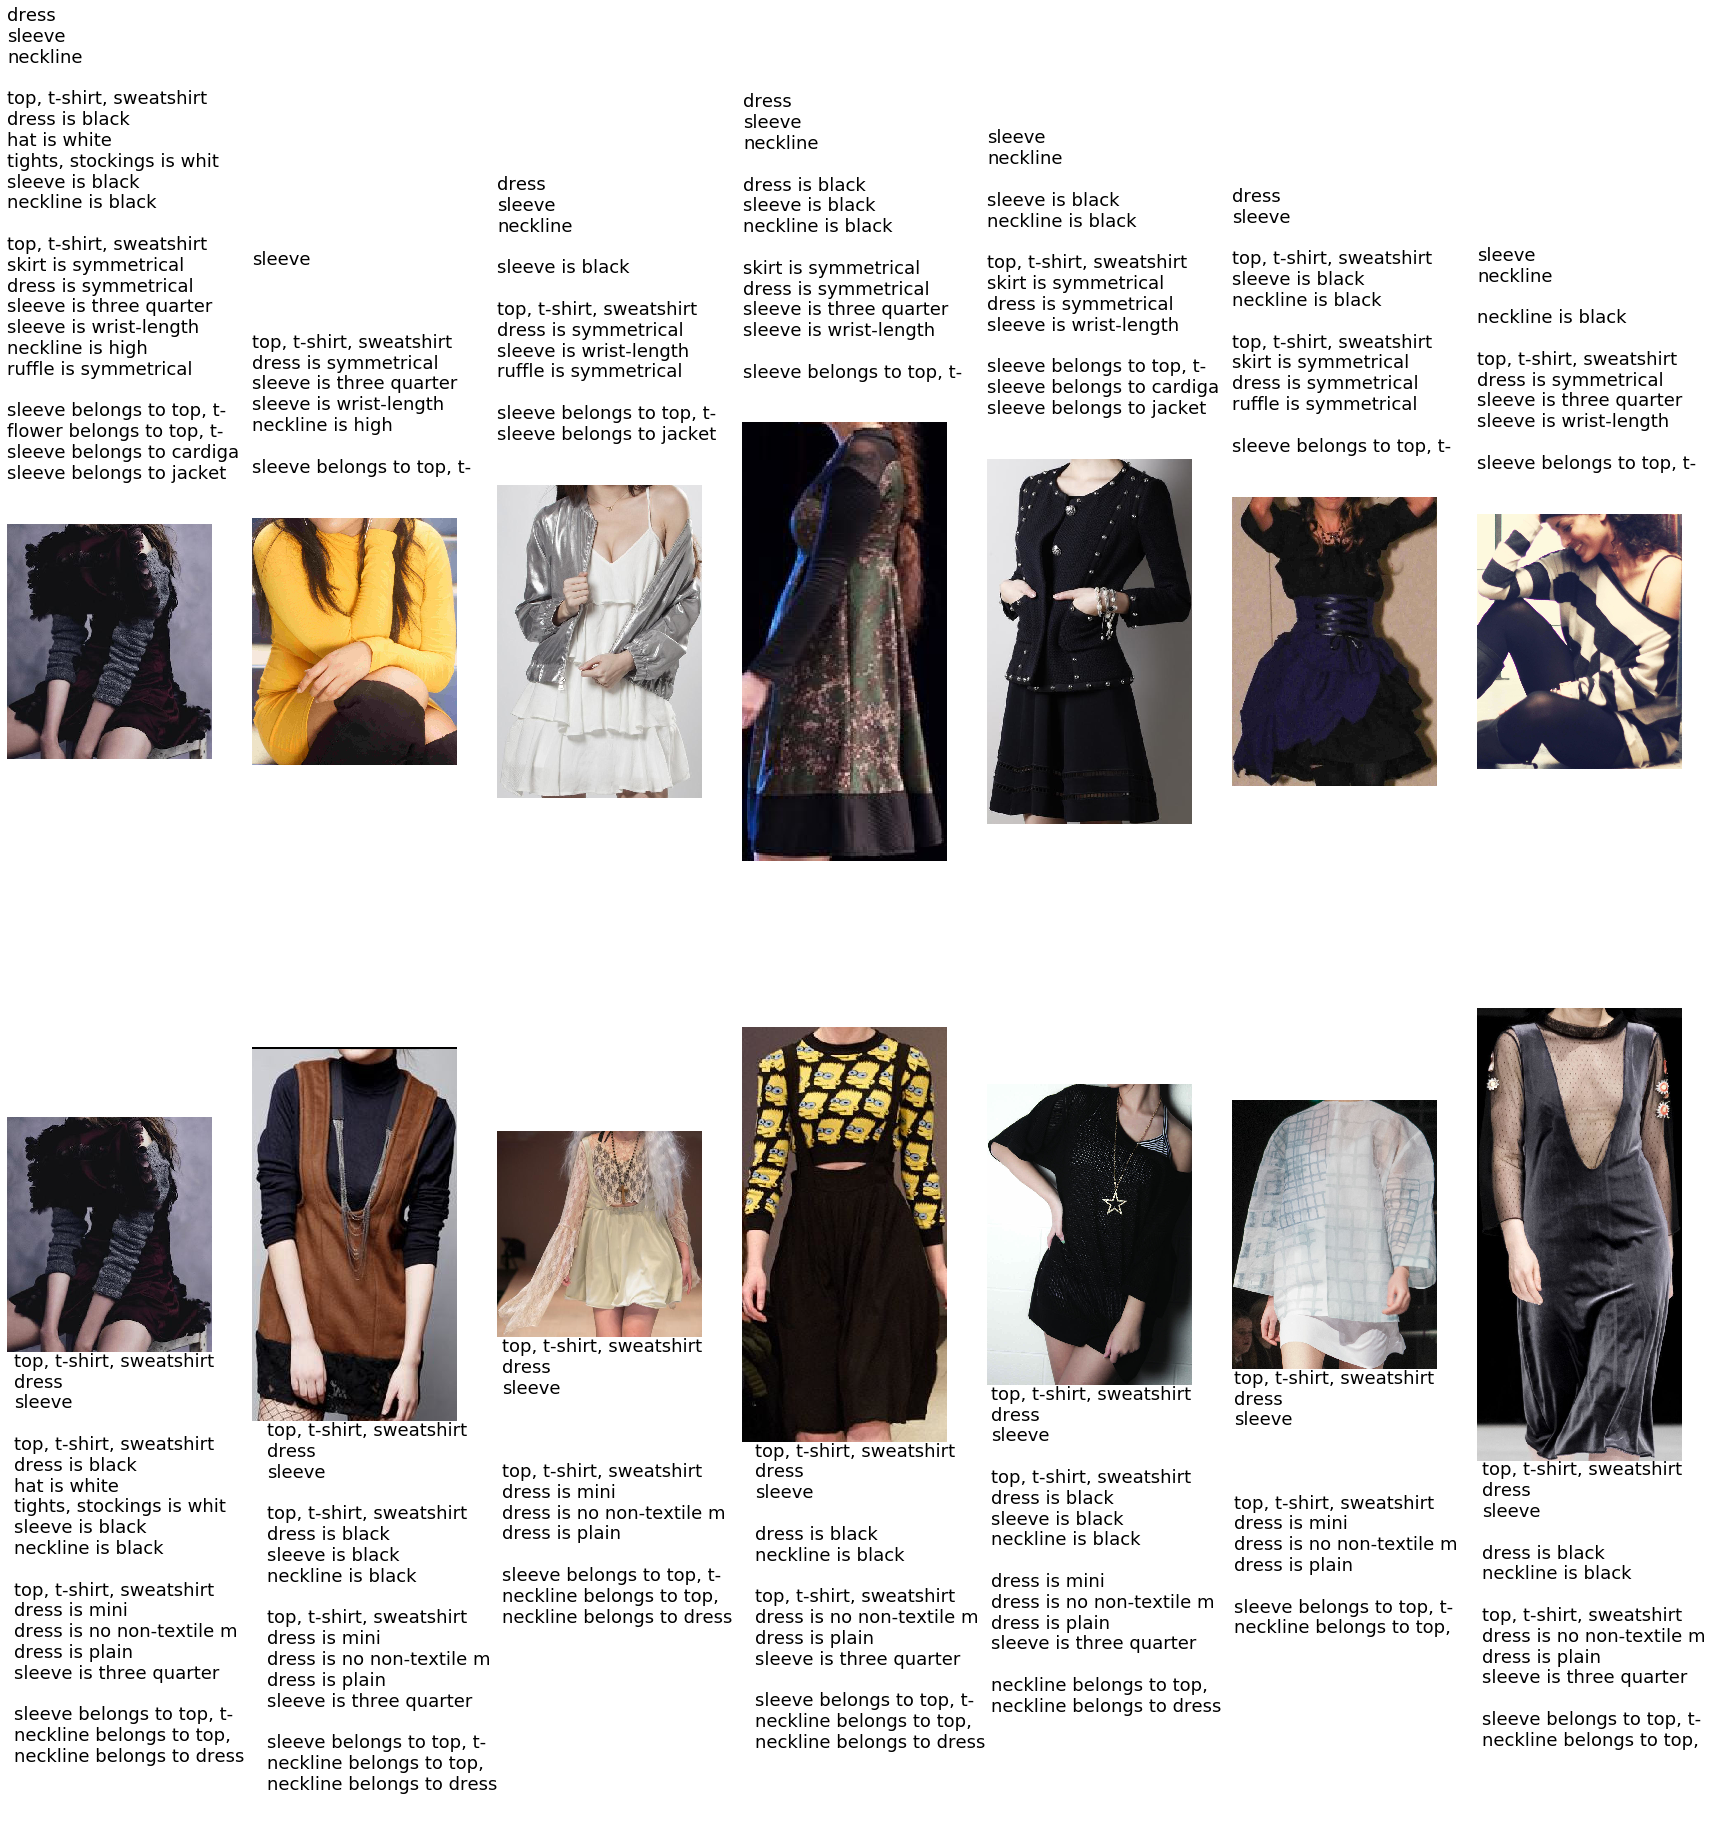

In [238]:
import pandas as pd
img_ind = 988 #988#3#15#16
score1=True
score2=True
score3=True
score4 = True
truncate_title_at =25

order = ["score1", "score2", "score3","score4"]

prd_df = pd.DataFrame({"score1":pred_score1_similarity_matrix[img_ind],"score2":pred_score2_similarity_matrix[img_ind],"score3":pred_score3_similarity_matrix[img_ind],"score4":gt_score4_similarity_matrix[img_ind]},columns=["score1","score2","score3","score4"])
prd_df.iloc[img_ind][:] = 999999
prd_sorted_ids = prd_df.sort_values(order, ascending = (False, False,False, False)).index

gt_df = pd.DataFrame({"score1":gt_score1_similarity_matrix[img_ind],"score2":gt_score2_similarity_matrix[img_ind],"score3":gt_score3_similarity_matrix[img_ind],"score4":gt_score4_similarity_matrix[img_ind]},columns=["score1","score2","score3","score4"])
gt_df.iloc[img_ind][:] = 999999
gt_sorted_ids = gt_df.sort_values(order, ascending = (False, False,False, False)).index

num_rows =2
num_cols = 7

plt.figure(figsize=(30, 20))
plt.axis('off')

i=1
for pred_id, gt_id in zip(prd_sorted_ids[:num_cols], gt_sorted_ids[:num_cols]):
    #print(" ")
    #print(pred_id, pred_score1_similarity_matrix[pred_id][img_ind],pred_score3_similarity_matrix[pred_id][img_ind],pred_similarity,gt_id, gt_similarity)
    title_pred = ""
    
    if score1:
        matched = [str((categories_id_to_name[i]))[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[pred_id]["pred_score1"][:,None]*SG2Vec_test[img_ind]["pred_score1"][:,None] > 0)]
        title_pred += "\n".join(matched)+"\n\n"
    if score4:
        matched = [(categories_id_to_name[i]+" is "+color_dct[SG2Vec_test[pred_id]["gt_score4"][i]])[:truncate_title_at] for i,j in np.argwhere(np.logical_and(SG2Vec_test[pred_id]["gt_score4"][:,None]==SG2Vec_test[img_ind]["gt_score4"][:,None] , SG2Vec_test[img_ind]["gt_score4"][:,None]>0, SG2Vec_test[pred_id]["gt_score4"][:,None]>0))]
        title_pred += "\n".join(matched)+"\n\n"
    if score3:
        matched = [(categories_id_to_name[i]+" is "+prd_cats[j].split(" (")[0])[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[pred_id]["pred_score3"]*SG2Vec_test[img_ind]["pred_score3"] > 0)]
        title_pred += "\n".join(matched)+"\n\n"
    if score2:
        matched = [(categories_id_to_name[j] + " belongs to "+ categories_id_to_name[i])[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[pred_id]["pred_score2"]*SG2Vec_test[img_ind]["pred_score2"] > 0)]
        title_pred += "\n".join(matched)+"\n\n"
    
    title_gt = ""
    if score1:
        matched = [str((categories_id_to_name[i]))[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[gt_id]["gt_score1"][:,None]*SG2Vec_test[img_ind]["gt_score1"][:,None] > 0)]
        title_gt += "\n".join(matched)+"\n\n"
    
    if score4:
        matched = [(categories_id_to_name[i]+" is "+color_dct[SG2Vec_test[gt_id]["gt_score4"][i]])[:truncate_title_at] for i,j in np.argwhere(np.logical_and(SG2Vec_test[gt_id]["gt_score4"][:,None]==SG2Vec_test[img_ind]["gt_score4"][:,None] , SG2Vec_test[img_ind]["gt_score4"][:,None]>0, SG2Vec_test[gt_id]["gt_score4"][:,None]>0))]
        title_gt += "\n".join(matched)+"\n\n"
    
    if score3:
        matched = [(categories_id_to_name[i]+" is "+prd_cats[j].split(" (")[0])[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[gt_id]["gt_score3"]*SG2Vec_test[img_ind]["gt_score3"] > 0)]
        title_gt += "\n".join(matched)+"\n\n"
    
    if score4:
        matched = [(categories_id_to_name[j] + " belongs to "+ categories_id_to_name[i])[:truncate_title_at] for i,j in np.argwhere(SG2Vec_test[gt_id]["gt_score2"]*SG2Vec_test[img_ind]["gt_score2"] > 0)]
        title_gt += "\n".join(matched)+"\n\n"
    
    plt.subplot(num_rows, num_cols, i)
    plt.axis('off')
    img = Image.open(rel_output[pred_id]["image"])
    img = img.crop(get_limits_of_bbox(rel_output[pred_id]['gt_sbj_boxes'] , rel_output[pred_id]['gt_obj_boxes']) ) 
    #img.save( "./Fig52/"+str(score1)+str(score2)+str(score3)+str(score4)+str(i)+".jpg")
    plt.imshow(np.asarray(img).astype(np.uint8))
    plt.text(0, 0, title_pred, fontsize=18,verticalalignment="bottom")
    

    
    plt.subplot(num_rows, num_cols, i+num_cols)
    plt.axis('off')
    img = Image.open(rel_output[gt_id]["image"])
    img = img.crop(get_limits_of_bbox(rel_output[gt_id]['gt_sbj_boxes'] , rel_output[gt_id]['gt_obj_boxes'])  )    
    img.save( "./Fig52/"+"gt"+str(i)+".jpg")
    plt.imshow(np.asarray(img).astype(np.uint8))
    plt.text(15, img.size[1] , title_gt, fontsize=18,verticalalignment="top")
    i+=1
    
plt.show()    

In [271]:
import random
def recall_at_k_per_image(img_id,k,is_random = False,score1=True,score2=True, score3=True, score4=False):
    pred_sim_score = np.zeros(len(pred_score3_similarity_matrix[img_id]))
    gt_sim_score = np.zeros(len(gt_score3_similarity_matrix[img_id]))
    
    if score1:
        pred_sim_score +=  pred_score1_similarity_matrix[img_id]        
    if score2:
        pred_sim_score +=  pred_score2_similarity_matrix[img_id]        
    if score3:
        pred_sim_score +=  pred_score3_similarity_matrix[img_id]
    if score4:
        pred_sim_score += gt_score4_similarity_matrix[img_ind]
        gt_sim_score += gt_score4_similarity_matrix[img_ind]
    
    gt_sim_score += gt_score2_similarity_matrix[img_id]    
    gt_sim_score += gt_score3_similarity_matrix[img_id]    
    gt_sim_score += gt_score1_similarity_matrix[img_id]
    gt_sim_score[img_id] = -1
    pred_sim_score[img_id] = -1
    
    if is_random:
        set_pred = set(random.sample(range(filter_images),k=k))
    else:    
        set_pred_topk = set(np.argsort(pred_sim_score[:filter_images])[:-1-k:-1])#get top k ids ordered by desc similarity to the source
        set_pred_nonzeros = set(np.argwhere(pred_sim_score[:filter_images]>0).flatten())
        set_pred = set_pred_topk.intersection(set_pred_nonzeros)
        
    set_gt_topk = set(np.argsort(gt_sim_score[:filter_images])[:-1-k:-1])#get top k ids ordered by desc similarity to the source
    set_gt_nonzeros = set(np.argwhere(gt_sim_score[:filter_images]>10).flatten())
    set_gt = set_gt_topk.intersection(set_gt_nonzeros)
    
    
    return len(set_gt.intersection(set_pred))/len(set_gt) if len(set_gt)!=0 else 0

filter_images = 300
results_only_s1 = {}
results_only_s2 = {}
results_only_s3 = {}
results_s1_s2_s3 = {}
results_s1_s2_s3_s4 = {}
results_only_s4 = {}
results_random = {}
k_list = range(1,101,2)
for k in tqdm(k_list):
    results_s1_s2_s3[k] = np.mean(np.array([recall_at_k_per_image(i,k) for i in range(filter_images)]))
    results_only_s1[k] = np.mean(np.array([recall_at_k_per_image(i,k,score1=True,score2=False, score3=False) for i in range(filter_images)]))
    results_only_s2[k] = np.mean(np.array([recall_at_k_per_image(i,k,score1=False,score2=True, score3=False) for i in range(filter_images)]))
    results_only_s3[k] = np.mean(np.array([recall_at_k_per_image(i,k,score1=False,score2=False, score3=True) for i in range(filter_images)]))
    results_s1_s2_s3_s4[k] = np.mean(np.array([recall_at_k_per_image(i,k,score4=True) for i in range(filter_images)]))
    results_only_s4[k] = np.mean(np.array([recall_at_k_per_image(i,k,score1=False,score2=False, score3=False,score4=True) for i in range(filter_images)]))
    
    results_random[k] = np.mean(np.array([recall_at_k_per_image(i,k,is_random=True) for i in range(filter_images)]))
    
    

100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


In [281]:
with open('chart.pickle', 'wb') as handle:
    pickle.dump({"results_s1_s2_s3_s4":results_s1_s2_s3_s4,"results_s1_s2_s3":results_s1_s2_s3,"results_only_s1":results_only_s1,"results_only_s2":results_only_s2,"results_only_s3":results_only_s3,"results_random":results_random}, handle)



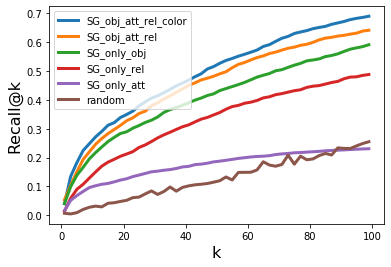

In [279]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['CMU Serif']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

fig, ax = plt.subplots()

ax.plot(k_list, list(results_s1_s2_s3_s4.values()), label='SG_obj_att_rel_color',linewidth=3)
ax.plot(k_list, list(results_s1_s2_s3.values()), label='SG_obj_att_rel',linewidth=3)
ax.plot(k_list, list(results_only_s1.values()), label='SG_only_obj',linewidth=3)
ax.plot(k_list, list(results_only_s2.values()), label='SG_only_rel',linewidth=3)
ax.plot(k_list, list(results_only_s3.values()), label='SG_only_att',linewidth=3)
#ax.plot(k_list, list(results_only_s4.values()), label='SG_only_color',linewidth=3)
ax.plot(k_list, list(results_random.values()), label='random',linewidth=3)
leg = ax.legend(loc='best')

plt.xlabel('k', fontsize=16)
plt.ylabel('Recall@k', fontsize=16)
plt.savefig("recall@k.pdf")
#plt.show()
